# run_car

In [1]:
import datetime
import numpy as np
import random

In [2]:
from cars.world import SimpleCarWorld
from cars.agent import SimpleCarAgent
from cars.physics import SimplePhysics
from cars.track import generate_map

In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from tqdm import tqdm_notebook

In [5]:
from functools import reduce

In [6]:
import pandas as pd

# базовый пример кода
```
if filename:
    agent = SimpleCarAgent.from_file(filename)
    w = SimpleCarWorld(1, m, SimplePhysics, SimpleCarAgent, timedelta=0.2)
    if evaluate:
        print(w.evaluate_agent(agent, steps))
    else:
        w.set_agents([agent])
        w.run(steps)
else:
    w = SimpleCarWorld(1, m, SimplePhysics, SimpleCarAgent, timedelta=0.2)
    w.run(steps)
```

In [7]:
def create_map(seed, agent):
    np.random.seed(seed)
    random.seed(seed)
    m = generate_map(8, 5, 3, 3)
    w = SimpleCarWorld([agent], m, SimplePhysics, None, timedelta=0.2)
    return w

# Агент

Пример `agent = SimpleCarAgent.from_file('network_config_agent_0_layers_9_6_1.txt')`

# Параметры

In [8]:
map_seeds = [3, 13, 23]

In [9]:
# За сколько шагов модель начинает учитывать вознаграждение
map_seed = map_seeds[0]

# Нарабатываем данные, учимся и оцениваемся

In [10]:
def norm_y(y):
    return y / 15.0

In [12]:
def mine_data(agent, agent_random_action,
              clear_history, map_seed, steps,
              epochs, mini_batch_size, eta, reward_shift, alpha):
    agent.RANDOM_ACTION_P = agent_random_action
    if clear_history:
        agent.clear_history()
    
    #mine data
    w = create_map(seed=map_seed, agent=agent)
    w.run(steps=tqdm_notebook(range(steps), desc="train", leave=False), visual=False, save=False)

    # prepare train data
    X_train = np.concatenate([agent.sensor_data_history, agent.chosen_actions_history], axis=1)
    y_train = np.array(agent.reward_history)
    # сглаживаем пики, чтобы сеть небольшая сеть могла дать адекватное предсказание
    mean_train_revard = y_train.mean()
    y_train = norm_y(y_train)
    
    y_train = np.pad(y_train, (0, reward_shift + 1), mode="constant")
    y_train = reduce(lambda a, b: a + b, [y_train[i:(i - reward_shift - 1)] * (alpha ** (i - 1))
                                          for i in range(1, reward_shift+1)])

    #train NN
    train_data = [(x[:, np.newaxis], y) for x, y in zip(X_train, y_train)]
    agent.neural_net.SGD(training_data=train_data,
                         epochs=epochs,
                         mini_batch_size=mini_batch_size,
                         eta=eta)
    train_rmse = agent.neural_net.evaluate(X_train.T, y_train)

    # evaluate
    w = create_map(seed=map_seed, agent=agent)
    mean_test_reward = w.evaluate_agent(agent, steps=tqdm_notebook(range(800), desc="test", leave=False), visual=False)
    log_message = f"""map_seed = {map_seed}
agent_random_action = {agent_random_action:.2f}
train_rmse = {train_rmse:.9f}
mean_train_revard = {mean_train_revard:.3f}
mean_test_reward  = {mean_test_reward:.3f}"""

    chart_count = agent.neural_net.num_layers
    plt.figure(figsize=(5 * chart_count, 2))
    for l in range(chart_count - 1):
        plt.subplot(1, chart_count, l+1)
        ax = sns.heatmap(agent.neural_net.weights[l])
        
    plt.subplot(1, chart_count, chart_count)    
    plt.text(0.05, 0.95, log_message, size=12, ha='left', va='top', family='monospace')
    
    plt.show()

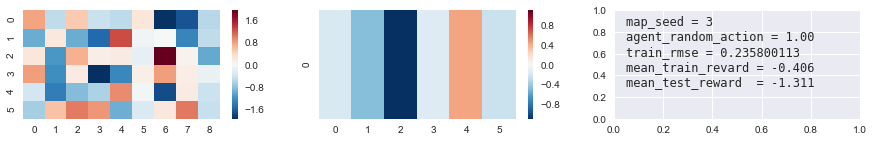

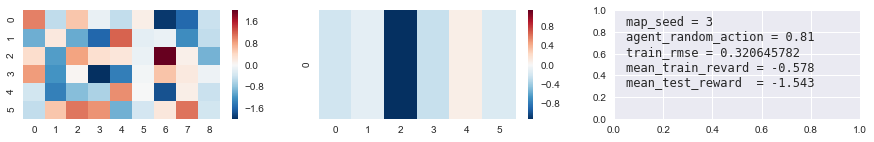

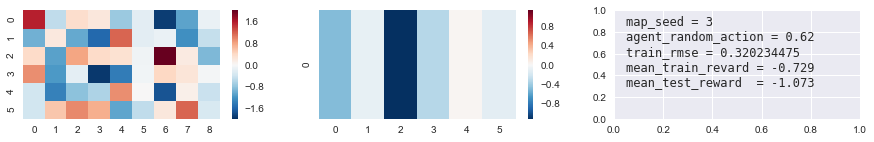

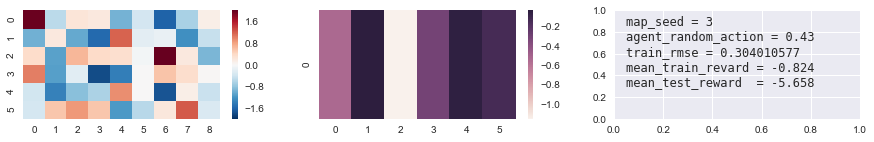

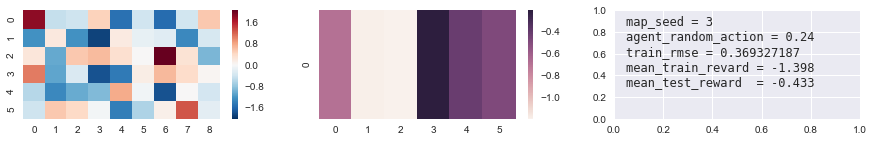

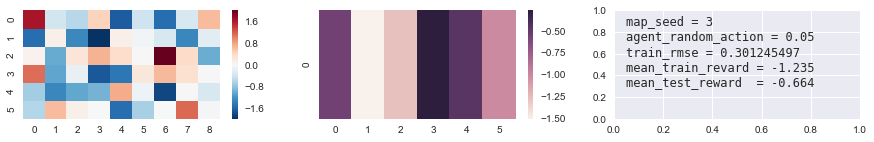

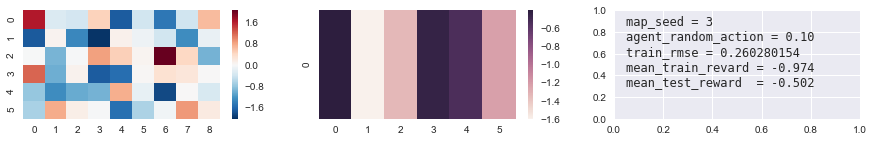

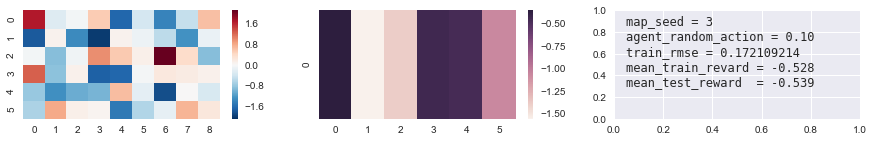

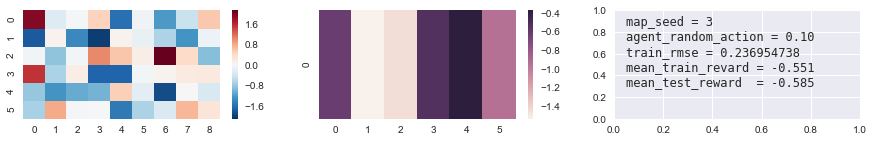

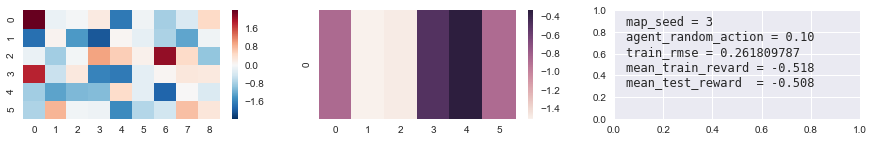

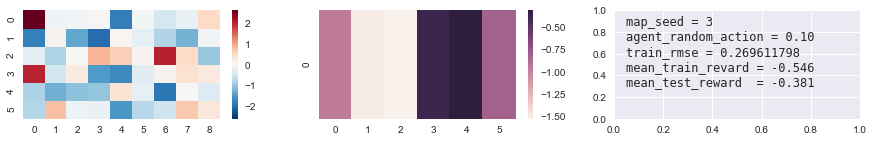

In [26]:
kvparams = {
    "clear_history": False,
    "map_seed": map_seed,
    "steps": 2000,
    "epochs": 40,
    "mini_batch_size": 100,
    "eta": 0.05,
    "reward_shift": 6,
    "alpha": 0.8
}

random.seed(42)
np.random.seed(42)
agent1 = SimpleCarAgent(name="Ivan", history_data=8000)

for agent_random_action in tqdm_notebook(np.arange(1, 0, -.19), desc="main_1"):
    mine_data(agent1, agent_random_action, **kvparams)
for _ in tqdm_notebook(range(5), desc="main_2"):
    mine_data(agent1, agent_random_action=0.1, **kvparams)

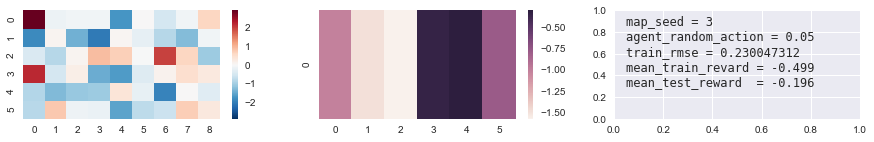

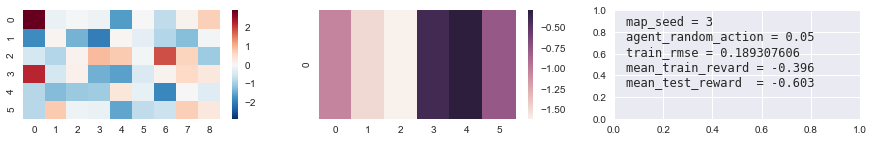

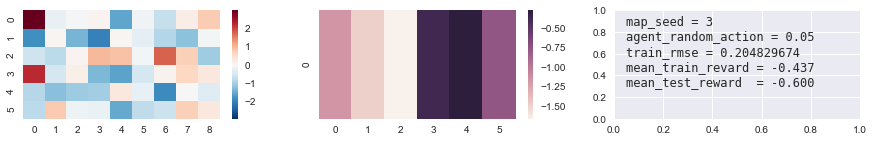

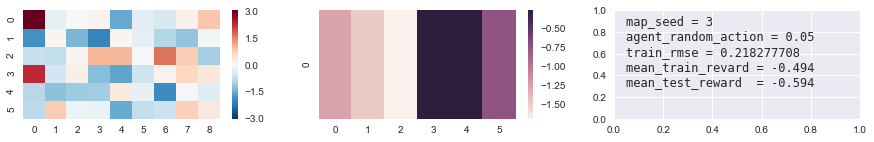

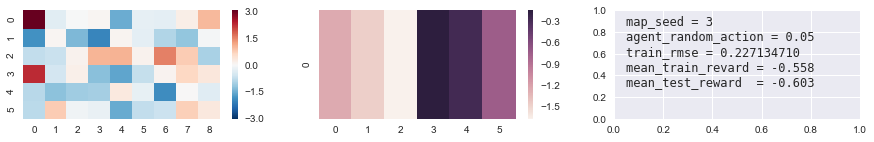

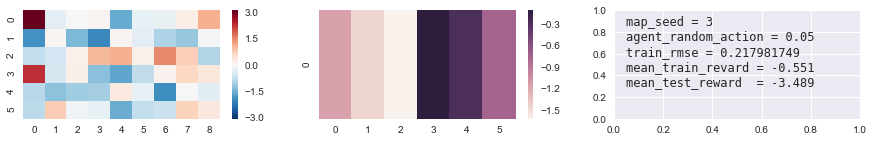

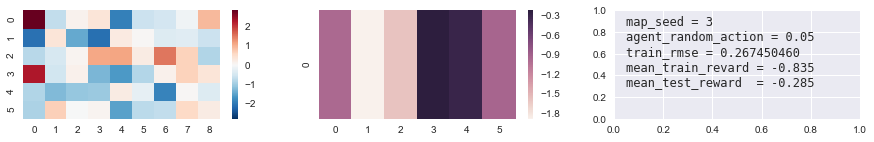

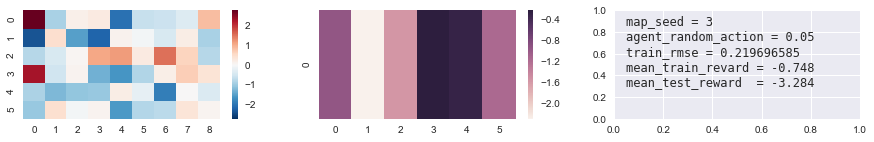

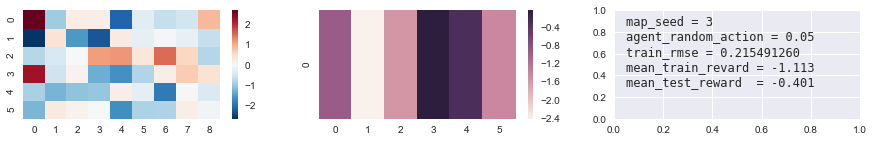

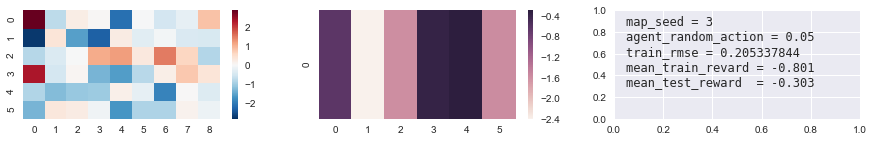

In [27]:
for _ in tqdm_notebook(range(10), desc="main_2"):
    mine_data(agent1, agent_random_action=0.05, **kvparams)

На первом слое: скорость, направление, лидары, руль, ускорение 

# Смотрим вживую

In [28]:
def visualize(agent, map_seed):
    agent.evaluate_mode=True
    print("visualize on map = {}".format(map_seed))
    agent.clear_history()
    w = create_map(seed=map_seed, agent=agent)
    w.run(steps=None, visual=True, save=False)

In [29]:
visualize(agent1, map_seed)

visualize on map = 3


# Отладка

In [ ]:
raise Exception("Здесь отладка")

In [30]:
agent_dbg = agent1

In [34]:
# prepare train data
X_train = np.concatenate([agent_dbg.sensor_data_history, agent_dbg.chosen_actions_history], axis=1)
y_train = np.array(agent_dbg.reward_history)
y_train = norm_y(y_train)
y_clean = y_train.copy()
mean_train_revard = y_train.mean()
mean_train_revard

-0.020243741560851465

In [35]:
reward_shift = 6
alpha = 0.8

In [36]:
y_train = np.pad(y_train, (0, 2 * reward_shift), mode="constant")
y_train = reduce(lambda a, b: a + b, [y_train[i:(-2 * reward_shift + i)] * (alpha ** (i - 1))
                                      for i in range(1, reward_shift+1)])

In [37]:
y_predict = agent_dbg.neural_net.feedforward(X_train.T)

In [38]:
pd_visual = pd.DataFrame(X_train,
                         columns=["velocity", "angle"] +
                         ["lid{}".format(i) for i in range(agent_dbg.rays)] +
                         ["steering", "acceleration"])
pd_visual["y_clean"] = y_clean
pd_visual["y_train"] = y_train
pd_visual["y_predict"] = y_predict.flatten()

In [39]:
pd_visual.head(15)

,velocity,angle,lid0,lid1,lid2,lid3,lid4,steering,acceleration,y_clean,y_train,y_predict
0,0.000000,-0.171753,9.810891,1.998454,1.317369,1.148346,2.116700,0.0,-0.75,-0.213333,-0.170667,-0.120655
1,0.045000,0.171875,2.123930,6.445471,1.446754,1.855483,9.810107,0.0,-0.75,0.000000,-0.213333,0.002618
2,0.105000,-0.171713,9.811152,1.996445,1.315869,1.147038,2.114290,0.0,-0.75,-0.213333,0.000000,-0.136497
3,0.045000,-0.171551,9.812197,1.988409,1.309869,1.141808,2.104649,0.0,-0.75,0.000000,0.000000,-0.129593
4,0.195000,0.172201,2.143211,6.419613,1.434754,1.840093,9.808017,1.0,-0.75,0.000000,0.000000,0.002508
5,0.246018,-0.194170,1.450776,7.897463,1.927895,1.462344,3.072175,1.0,-0.75,0.000000,0.000000,-0.000936
6,0.322529,-0.683652,1.168275,1.827597,9.993371,1.399620,1.596541,-1.0,0.00,0.000000,0.000000,-0.012734
7,0.322529,-0.819627,1.162500,1.489014,9.547272,1.850407,1.425631,1.0,0.75,0.000000,0.000000,-0.007200
8,0.355704,-0.673978,1.173612,1.897709,9.951777,1.370530,1.556423,1.0,0.75,0.000000,0.000000,-0.001974
9,0.413450,-0.335038,1.391194,4.703508,2.458940,1.263910,2.229783,1.0,-0.75,0.000000,0.000000,-0.000469


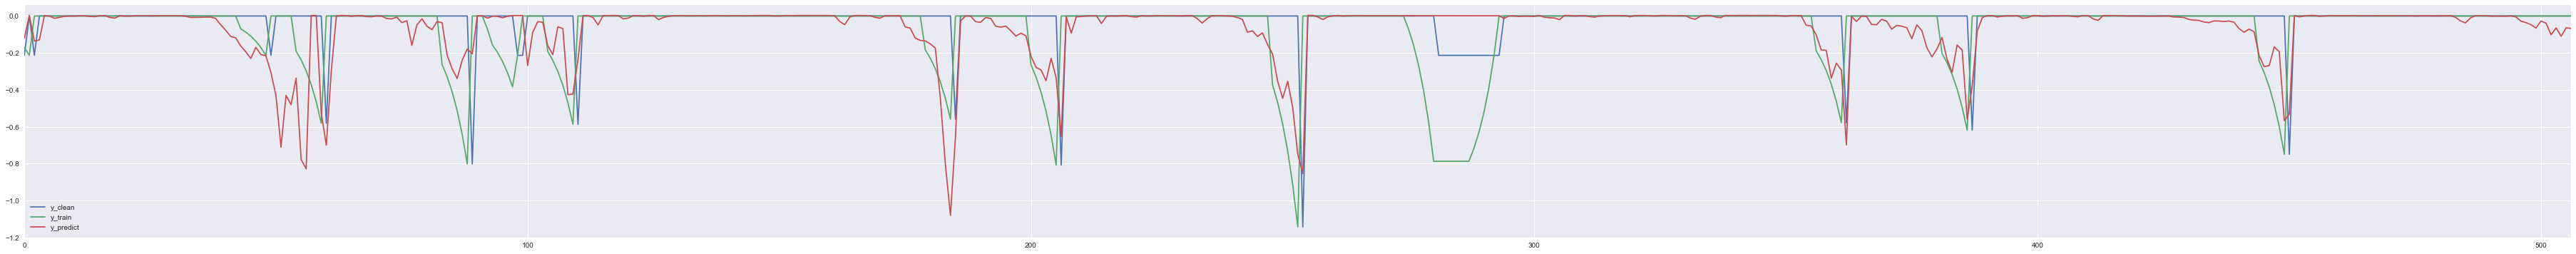

In [40]:
pd_visual.plot(y=["y_clean", "y_train", "y_predict"], figsize=(64, 6))

In [ ]:

    train_rmse = agent.neural_net.evaluate(X_train.T, y_train)
    
    if clip:
        for i, w in enumerate(agent.neural_net.weights):
            agent.neural_net.weights[i] = np.clip(w, -clip, clip)
        for i, b in enumerate(agent.neural_net.biases):
            agent.neural_net.biases[i] = np.clip(b, -clip, clip)   

    # evaluate
    w = create_map(seed=map_seed, agent=agent)
    mean_test_reward = w.evaluate_agent(agent, steps=tqdm_notebook(range(800), desc="test", leave=False), visual=False)
    log_message = f"{map_seed}, {agent_random_action:.2f}, {train_rmse:.5f}, {mean_train_revard:.4f}, {mean_test_reward:.4f}"
    print(log_message)
    plt.figure(figsize=(2 * (agent.neural_net.num_layers - 1), 1))
    for l in range(agent.neural_net.num_layers - 1):
        plt.subplot(1, agent.neural_net.num_layers - 1, l+1)
        ax = sns.heatmap(agent.neural_net.weights[l])
    plt.show()